In [1]:
import sys
import numpy as np
import matplotlib
import scipy
from IPython.display import Image
from IPython.core.display import HTML 

print('Python version:\n{}\n'.format(sys.version))
print('Numpy version:\t\t{}'.format(np.__version__))
print('matplotlib version:\t{}'.format(matplotlib.__version__))
print('Scipy version:\t\t{}'.format(scipy.__version__))

Python version:
3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]

Numpy version:		1.16.2
matplotlib version:	3.0.3
Scipy version:		1.2.1


# Digital Signals

Before we dive into the details of Fourier transformations, we need to review some fundamental concepts in signal processing. Recall that when we measure an analog signal e.g. intensity, voltage, pressure, etc., our measurement device makes use of an Analog to Digital Converter (ADC). The ADC converts the continous time  continuous amplitude signal to a discrete time and discrete amplitude by sampling the analog signal at a frequency referred to as the *sampling rate* and quantizing the measured amplitudes. 

If the sampling rate $f_{s}$ is not sufficiently large, we end up with a poor approximation to the original signal: high frequency components within the signal will be missed at low sampling rates. This can be made more precise by the sampling theorem which states:

\begin{equation*}
f_{s} > 2f_{m}
\end{equation*}

where $f_{m}$ is the maximum frequency or that can be reliably recorded and is sometimes called the *nyquist frequency* or *folding frequency*.

# Frequency Resolution and the FFT

The Fast Fourier Transform (FFT) is an indispensible tool in signal processing as it allows you to decompose a signal into its frequency components. In other words, if we have a digital signal in the time domain, the FFT can convert that signal into the frequency domain. For example, in the acoustic case, the FFT could allow you to extract the frequencies of notes making up a musical chord played into a microphone. In general, for a quantized digital signal $x_{n}$ with $N$ samples the FFT is defined as:

\begin{equation*}
X(k) = FFT[x_{n}] = \sum_{n=0}^{N-1} x_{n}\exp{-\frac{j2\pi kn}{N}}, k=0,1,...,N-1
\end{equation*}

where $k$ is a discrete frequency index. For each value of $k$, we sum over all $N$ samples putting $k$ into the argument of the exponential. The resulting value is a complex number $X(k)$ of which we can calculate the magnitude:

\begin{equation*}
|X(k)| = \sqrt{X_{R}^{2}(k) + X_{I}^{2}(k)}
\end{equation*}

and phase:

\begin{equation*}
\phi(k) = \arctan(\frac{X_{I}(k)}{X_{R}(k)})
\end{equation*}

Notice that we set the number of samples for $k$ to be equal to that of $x_{n}$. Also, the frequencies start at 0Hz and increment by $k\frac{f_{s}}{{N}}$ up to $\frac{N}{N-1}f_{s}$ Hz. For example if we have a 16-point CD quality audio sample ($f_{s}$=44.1kHz), we will have a frequency spectrum from 0 to 41.3 kHz. Recall, we said that the max frequency that can be reliably detected for a given sampling rate is $f_{s} > 2f_{m}$ but the FFT produces frequencies all the way up to $\frac{N}{N-1}f_{s}$ Hz. This is why the max frequency is sometimes called the folding frequency: at the point $f_{s} = 2f_{m}$, the magnitude spectrum *folds* or repeats itself. Let's see this in an example.

# FFT Example 1

In this example, we are going to define a function simple_fft() that takes in four parameters: freq, fft_size, nsamples, and period. The parameter fft_size determines the frequency resolution of the frequency domain. In general, the frequency resolution is inversely proportional to the sampling rate and directly proportional to the fft_size. Therefore, at high sampling rates, you need larger FFT sizes to accurately resolve frequency components. Let's use simple_fft() to generate a 100 Hz sine wave sampled at 1 kHz over 100ms and take a 2048 point FFT.

/home/cwseitz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


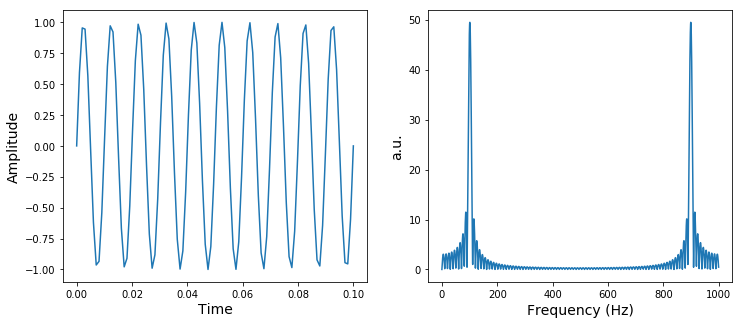

##################################################
Time Resolution: 10.0 ms/step
Frequency Resolution: 0.48828125 Hz/step
Set Frequency: 100 Hz
Measured Frequency: 101.07421875 Hz


In [11]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft
from scipy.signal import find_peaks

def simple_fft(freq=20,
               fft_size=2048,
               nsamples=50,
               period=1):

    sample_rate = nsamples/period
    tres = 1/sample_rate #time resolution
    fres = sample_rate/fft_size #frequency resolution

    # """
    # ~~~~~~Generate signal, do FFT~~~~~
    # """

    t = np.linspace(0, period, nsamples)
    x = np.sin(2*np.pi*freq*t)
    f = np.arange(fft_size)*fres
    mag = np.abs(fft(x,n=fft_size))
    peaks, props = find_peaks(mag, height=.5*mag.max())
    peaks = fres*peaks

    # """
    # ~~~~~~Plot results~~~~~
    # """

    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    ax[0].plot(t, x)
    ax[0].set_xlabel('Time', fontsize=14)
    ax[0].set_ylabel('Amplitude', fontsize=14)
    ax[1].plot(f, mag)
    ax[1].set_xlabel('Frequency (Hz)', fontsize=14)
    ax[1].set_ylabel('a.u.', fontsize=14)
    plt.show()

    # """
    # ~~~~~~Print results~~~~~
    # """

    tres = tres*1e4
    mag[fft_size//2:] = 0
    
    print('#'*50)
    print('Time Resolution: %s ms/step' % tres)
    print('Frequency Resolution: %s Hz/step' % fres)
    print('Set Frequency: %s Hz' % freq)
    print('Measured Frequency: %s Hz' % peaks[0])


sample_rate = 1000 #Hz
period = .1 #sec
nsamples = sample_rate*period

simple_fft(freq=100,
           fft_size=2048,
           nsamples=nsamples,
           period=period)

# FFT Example 2

This time we will use modify simple_fft() to superimpose 3 frequencies and try and resolve them in the frequency domain. Consider what happens when you play a C major triad consisting of notes C, E, and G on a piano. If we start at middle C, we are superimposing three sinusoids with fourth-order frequencies 261, 329, and 392 Hz. Let's take a look at these waveforms and their sum over a 10ms time window with a 44.1kHz sample rate:

/home/cwseitz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


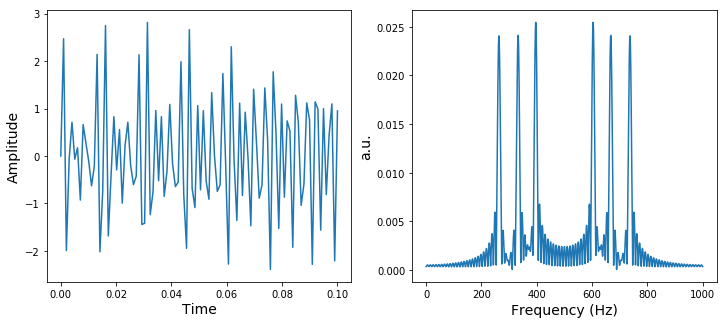

##################################################
Time Resolution: 10.0 ms/step
Frequency Resolution: 0.48828125 Hz/step
Set Frequencies: [261, 329, 392] Hz
Measured Frequencies: [263.18359375 332.51953125 396.484375   603.515625   667.48046875
 736.81640625] Hz


In [12]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft

def simple_fft(freq=[10, 20, 30],
               fft_size=2048,
               nsamples=50,
               period=1):

    sample_rate = nsamples/period
    tres = 1/sample_rate #time resolution
    fres = sample_rate/fft_size #frequency resolution

    # """
    # ~~~~~~Generate signal, do FFT~~~~~
    # """

    t = np.linspace(0, period, nsamples)
    x = np.sin(2*np.pi*freq[0]*t) + np.sin(2*np.pi*freq[1]*t) + np.sin(2*np.pi*freq[2]*t)
    f = np.arange(fft_size)*fres
    mag = np.abs(fft(x,n=fft_size))/fft_size
    peaks, props = find_peaks(mag, height=.5*mag.max())
    peaks = fres*peaks

    # """
    # ~~~~~~Plot results~~~~~
    # """

    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    ax[0].plot(t, x)
    ax[0].set_xlabel('Time', fontsize=14)
    ax[0].set_ylabel('Amplitude', fontsize=14)
    ax[1].plot(f, mag)
    ax[1].set_xlabel('Frequency (Hz)', fontsize=14)
    ax[1].set_ylabel('a.u.', fontsize=14)
    plt.show()

    # """
    # ~~~~~~Print results~~~~~
    # """

    tres = tres*1e4
    mag[fft_size//2:] = 0
    
    print('#'*50)
    print('Time Resolution: %s ms/step' % tres)
    print('Frequency Resolution: %s Hz/step' % fres)
    print('Set Frequencies: %s Hz' % freq)
    print('Measured Frequencies: %s Hz' % peaks)


sample_rate = 1000 #Hz
period = .1 #sec
nsamples = sample_rate*period

simple_fft(freq=[261,329,392],
           fft_size=2048,
           nsamples=nsamples,
           period=period)